In [1]:
%env XLA_PYTHON_CLIENT_ALLOCATOR=platform

env: XLA_PYTHON_CLIENT_ALLOCATOR=platform


In [2]:
import os
import jax
import time
import optax
import numpy as np
import equinox as eqx
import matplotlib as mpl
import matplotlib.pyplot as plt
from jax import numpy as jnp, random, config
from model import PINN
from pde import PDE
from pdekernel import PDEKernel
from derivative import Derivative
from residual import Residual
from sampler import Sampler
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display
from util import subset, map_span
# config
config.update("jax_enable_x64", True)
key = random.PRNGKey(1312)
key, subkey = random.split(key)

In [3]:
params0 = {
    "alpha_phi": 9.62e-5,
    "omega_phi": 1.663e7,
    "M": 8.5e-10 / (2 * 5.35e7),
    "A": 5.35e7,
    "L": 1e-11,
    "c_se": 1.0,
    "c_le": 5100/1.43e5,
    "x_range": (-50e-6, 50e-6),
    "t_range": (0, 1e5),
    "nx": 128,
    "nt": 128,
    "dc": 1.0-5100/1.43e5,
}
pde = PDE(**params0)
x_out, t_out, phi_out, c_out = pde.solve()
key, subkey = random.split(key)
X_out, T_out = jnp.meshgrid(x_out,t_out)
x_valid, t_valid, phi_valid, c_valid  = subset(subkey, 800, X_out.ravel(), T_out.ravel(), phi_out.ravel(), c_out.ravel())
x_valid = map_span(x_valid, params0["x_range"], (-0.5,0.5))
t_valid = map_span(t_valid, params0["t_range"], (0,1))

In [4]:
# set up the dimensionless PDE
params1 = {
    "alpha_phi": 9.62e-5,
    "omega_phi": 1.663e7,
    "A": 5.35e7,
    "c_se": 1.0,
    "c_le": 5100/1.43e5,
    "x_range_phys": (-50e-6, 50e-6),
    "t_range_phys": (0, 1e5),
    "L": 1e-11,
    "M": 8.5e-10 / (2 * 5.35e7),
    "dc": 1.0-5100/1.43e5
}
pdekernel = PDEKernel(params1)

In [5]:
# set up the model
inp_idx = {'x':0, 't':1}
out_idx = {'phi':0, 'c':1}
width = 16
depth = 4
model = PINN(inp_idx, out_idx, width, depth)

In [6]:
# set up derivative
phys_span = {'x':pdekernel.x_range_phys, 't':pdekernel.t_range_phys} # the physical span is now a dimensionless span
norm_span = {'x':(-0.5,0.5), 't':(0,1)}
d = Derivative(inp_idx, out_idx, phys_span, norm_span)
d.create_deriv_fn('phi_t')
d.create_deriv_fn('phi_x')
d.create_deriv_fn('phi_2x')
d.create_deriv_fn('c_t')
d.create_deriv_fn('c_x')
d.create_deriv_fn('c_2x')

In [7]:
# set up sampler
s = Sampler()

def newsample(key, n):
    keys = random.split(key,5)
    inp = {k: {} for k in ['ic', 'bc', 'colloc','data']}
    inp['ic']['x'] = s.get_sample(keys[0],[30,40,30],[(-0.5,-0.1),(-0.1,0.1),(0.1,0.5)])
    inp['ic']['t'] = s.get_sample(keys[0],[100],[(0,0)])
    inp['bc']['x'] = s.get_sample(keys[1],[50,50],[(-0.5,-0.5),(0.5,0.5)])
    inp['bc']['t'] = jnp.tile(s.get_sample(keys[1],[50],[(0,1)]), (2,))
    x_colloc = s.get_sample(keys[2],[32],[(-0.5,0.5)])
    t_colloc = s.get_sample(keys[3],[32],[(0,1)])
    X_colloc, T_colloc = jnp.meshgrid(x_colloc,t_colloc)
    inp['colloc']['x'], inp['colloc']['t'] = X_colloc.ravel(), T_colloc.ravel()
    x_sub, t_sub, phi_sub, c_sub = subset(keys[4],500,x_valid, t_valid, phi_valid, c_valid)
    inp['data']['x'] = x_sub
    inp['data']['t'] = t_sub
    inp['data']['phi'] = phi_sub
    inp['data']['c'] = c_sub 
    return inp

def subsample(key, sample):
    keys = random.split(key,4)
    size = {'ic':30, 'bc':30, 'colloc':64, 'data': 64}
    inp = {k: {} for k in ['ic', 'bc', 'colloc','data']}
    inp['ic']['x'], inp['ic']['t'] = subset(keys[0], size['ic'], sample['ic']['x'], sample['ic']['t'])
    inp['bc']['x'], inp['bc']['t'] = subset(keys[1], size['bc'], sample['bc']['x'], sample['bc']['t'])
    inp['colloc']['x'], inp['colloc']['t'] = subset(keys[2], size['colloc'], sample['colloc']['x'], sample['colloc']['t'])
    inp['data']['x'], inp['data']['t'] = subset(keys[3], size['data'], sample['data']['x'], sample['data']['t'])
    inp['data']['phi'], inp['data']['c'] = subset(keys[3], size['data'], sample['data']['phi'], sample['data']['c'])
    return inp

key, subkey = random.split(key)
sample = newsample(subkey, 0)

In [9]:
# set up the residual
r = Residual(phys_span, norm_span, pdekernel, d)
r.compute_loss(model,sample)

{'ic': Array(0.64240354, dtype=float32),
 'bc': Array(0.6700173, dtype=float32),
 'ac': Array(1.7689746e-07, dtype=float32),
 'ch': Array(1.406211e-05, dtype=float32),
 'data': Array(0.5383481, dtype=float32)}

In [10]:
r.compute_ntk_weights(model,sample)

{'ic': Array(3.04635072, dtype=float64),
 'bc': Array(2.96848802, dtype=float64),
 'ac': Array(749149.86470046, dtype=float64),
 'ch': Array(9861.79145273, dtype=float64),
 'data': Array(2.98718066, dtype=float64)}

In [11]:
# initialize the hyper parameters
total_step = 10000   # Total training steps
sp1 = 50  # Resampling frequency
sp2 = 50  # NTK weighting frequency
sp3 = 2000 # log frequency

# initialize the optimizer
max_grad_norm = 100.0
optimizer = optax.chain(
    optax.clip_by_global_norm(max_grad_norm),
    optax.adam(1e-3),
)
params, static = eqx.partition(model, eqx.is_inexact_array)
opt_state = optimizer.init(params)

# initialize the weight
weight_dict = {'ic':1.0, 'bc':1.0, 'ch':1.0, 'ac':1.0, 'data':1.0}
# initialize the carry
init = (subkey, 0, sample, weight_dict, params, opt_state, jnp.inf, params)

In [12]:
def log_fn(step, weight_dict, loss_dict):
    weight_arr = jnp.array([weight_dict[k] for k in ['ic', 'bc', 'ac', 'ch', 'data']])
    loss_arr = jnp.array([loss_dict[k] for k in ['ic','bc','ac','ch','data']])
    total_loss = jnp.dot(weight_arr, loss_arr)

    jax.debug.print(
        (
            "Step {}: total_loss = {:.4e}\n"
            "  Loss  ['ic', 'bc', 'ac', 'ch', 'data'] = [{:.4e},{:.4e},{:.4e},{:.4e},{:.4e}]\n"
            "  Weight     ['ic', 'bc', 'ac', 'ch', 'data'] = [{:.4e},{:.4e},{:.4e},{:.4e},{:.4e}]"
        ),
        step, total_loss,
        loss_arr[0], loss_arr[1], loss_arr[2], loss_arr[3],loss_arr[4],
        weight_arr[0], weight_arr[1], weight_arr[2], weight_arr[3],weight_arr[4]
    )

In [13]:
def train_step(carry, _):
    """
    Performs a single training step, including resampling, NTK weight updates,
    loss calculation, and parameter optimization.
    """
    # 1. Unpack state and prepare for the current step
    key, step, sample, weight_dict, params, opt_state, best_loss, best_params = carry
    key, subkey1, subkey2 = jax.random.split(key, 3)
    
    # 2. Resample collocation points periodically based on model residuals
    sample = jax.lax.cond(
        step % sp1 == 0,
        lambda _: newsample(subkey1, step),
        lambda _: sample,
        operand = None,
    )

    # 3. Update NTK weights periodically using a memory-efficient scan
    def update_weight(key, step):
        model_temp = eqx.combine(params, static)
        return r.compute_ntk_weights(model_temp, subsample(key, sample), batch_size = 64)

    weight_dict = jax.lax.cond(
        step % sp2 == 0,
        lambda _: update_weight(subkey2, step),
        lambda _: weight_dict,
        operand = None,
    )

    # 4. Compute the main loss and its gradients
    def loss_fn(params, static, sample, weight_dict):
        model_temp = eqx.combine(params, static)
        loss_dict = r.compute_loss(model_temp,sample)
        weight_arr = jnp.array([weight_dict[k] for k in ['ic', 'bc', 'ac', 'ch']])
        loss_arr = jnp.array([loss_dict[k] for k in ['ic','bc','ac','ch']])
        total_loss = jnp.dot(weight_arr, loss_arr)

        return total_loss, loss_dict

    (loss, loss_dict), grads = jax.value_and_grad(loss_fn, has_aux=True)(
        params, static, sample, weight_dict
    )
    
    log_this = step % sp3 == 0
    def _log():
        log_fn(step, weight_dict, loss_dict)
    jax.lax.cond(log_this, _log, lambda: None)
    
    # 5. Apply updates to the optimizer state and model parameters
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)

    # 6. Track the best performing parameters
    best_loss, best_params = jax.lax.cond(
        loss < best_loss,
        lambda _: (loss, params),
        lambda _: (best_loss, best_params),
        operand = None,
    )

    # 7. Return the updated carry for the next training step
    new_carry = (key, step + 1, sample, weight_dict, params, opt_state, best_loss, best_params)
    return new_carry, loss_dict

In [14]:
start = time.time()
final_carry, loss_history = jax.lax.scan(train_step, init, xs=None, length=total_step + 1)
end = time.time()
print(f"The training time is {(end-start)/60:.2f} minutes")

Step 0: total_loss = 5.8819e+00
  Loss  ['ic', 'bc', 'ac', 'ch', 'data'] = [6.4285e-01,6.7013e-01,1.7585e-07,1.3807e-05,5.5722e-01]
  Weight     ['ic', 'bc', 'ac', 'ch', 'data'] = [3.0457e+00,2.9751e+00,7.5473e+05,9.8819e+03,2.9812e+00]
Step 2000: total_loss = 1.5610e+00
  Loss  ['ic', 'bc', 'ac', 'ch', 'data'] = [1.1847e-05,1.4476e-06,1.6266e-12,2.6493e-03,1.6762e-03]
  Weight     ['ic', 'bc', 'ac', 'ch', 'data'] = [8.5417e+02,9.0139e+02,5.6851e+09,1.0034e+00,9.1739e+02]
Step 4000: total_loss = 2.4445e-01
  Loss  ['ic', 'bc', 'ac', 'ch', 'data'] = [7.4282e-06,5.0998e-07,1.0880e-12,2.2894e-03,7.6056e-04]
  Weight     ['ic', 'bc', 'ac', 'ch', 'data'] = [2.8953e+02,3.2748e+02,2.9651e+09,1.0098e+00,3.1108e+02]
Step 6000: total_loss = 2.5305e-01
  Loss  ['ic', 'bc', 'ac', 'ch', 'data'] = [6.6815e-06,3.1759e-07,8.5634e-13,2.2355e-03,2.7507e-04]
  Weight     ['ic', 'bc', 'ac', 'ch', 'data'] = [7.7434e+02,8.1334e+02,5.6439e+09,1.0037e+00,8.7447e+02]
Step 8000: total_loss = 2.2659e-01
  Loss  

In [15]:
_,_,_,_,_,_,best_loss,best_params = final_carry
idx = 127
x = map_span(pde.x, params0["x_range"], (-0.5,0.5))
t = map_span(pde.t_eval[idx],params0["t_range"], (0,1))
model_best = eqx.combine(best_params, static)
P_pred, C_pred = model_best(x,t)

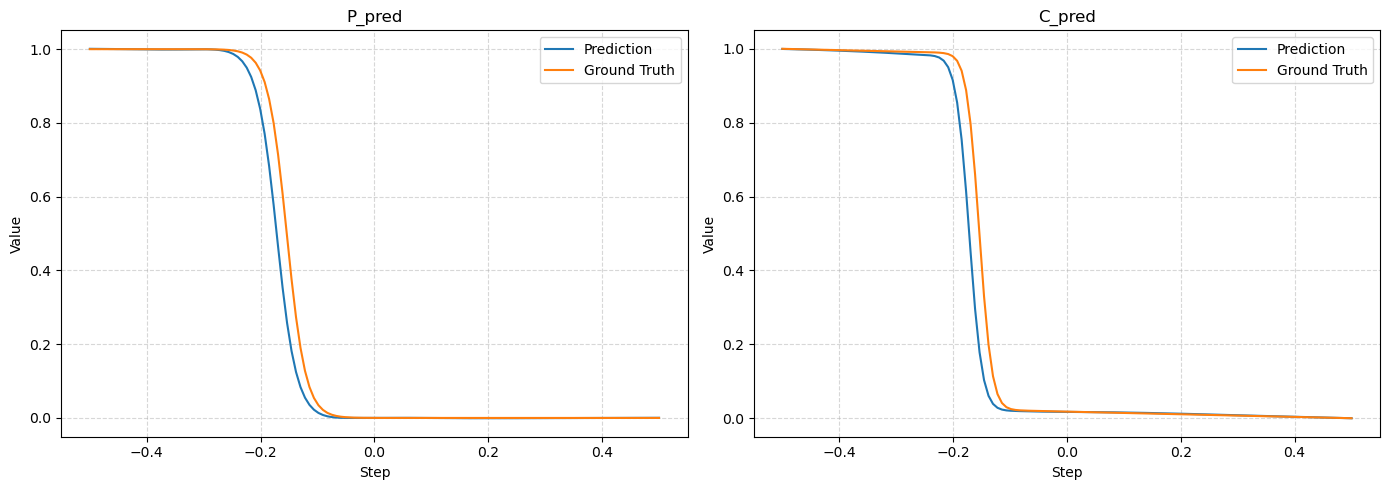

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))  # 1 row, 2 columns

# Plot P_pred on the first subplot
axes[0].plot(x, P_pred, label="Prediction")
axes[0].plot(x, phi_out[idx, :], label="Ground Truth")
axes[0].set_title("P_pred")
axes[0].set_xlabel("Step")
axes[0].set_ylabel("Value")
axes[0].grid(True, linestyle="--", alpha=0.5)
axes[0].legend()  # show labels

# Plot C_pred on the second subplot
axes[1].plot(x, C_pred, label="Prediction")
axes[1].plot(x, c_out[idx, :], label="Ground Truth")
axes[1].set_title("C_pred")
axes[1].set_xlabel("Step")
axes[1].set_ylabel("Value")
axes[1].grid(True, linestyle="--", alpha=0.5)
axes[1].legend()  # show labels

plt.tight_layout()
plt.show()